# TEST Simple Supervised Learning. Regression

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import helper

# helper.reproducible(seed=9)
sns.set()

## 1. Data Processing and Exploratory Data Analysis

In [2]:
data_size = 200
x = np.arange(data_size)
#x2 = np.arange(0,800,8)

y = np.array([-i * i + 1200 for i in np.linspace(-50, 50, num=data_size)])
y = y + np.random.normal(0,100,data_size) # add noise

df_original = pd.DataFrame({'x': x, 'y': y})
target = ['y']

print("rows: {} \ncolumns: {} \ntarget: {}".format(*df_original.shape, target))

rows: 200 
columns: 2 
target: ['y']


### Show original data

In [3]:
df_original.head(2)

,x,y
0,0,-1267.686552
1,1,-1296.349709


#### Numerical Data

In [4]:
df_original.describe(percentiles=[0.5])

,x,y
count,200.000000,200.000000
mean,99.500000,366.477534
std,57.879185,756.587253
min,0.000000,-1373.646055
50%,99.500000,621.707121
max,199.000000,1353.943548


#### Non-numerical Data

In [5]:
#df_original.describe(include=['O'])

#### Missing values

In [6]:
high_missing = helper.missing(df_original, limit=0.4)

No missing values found


### Transform data

In [7]:
df = df_original.copy() # Checkpoint

#### Enhance and add new features

#### Delete irrelevant features

In [8]:
droplist = [] + high_missing
assert len(set(droplist).intersection(set(target)))==0, 'Targets cannot be dropped'
df.drop(droplist, axis='columns', inplace=True)

#### Classify variables
Change categorical variables as dtype 'categorical' and sort columns: numerical + categorical + target

In [9]:
numerical = list(df.select_dtypes(include=[np.number]))

df = helper.classify_data(df, target, numerical=numerical)
pd.DataFrame(dict(df.dtypes), index=["Type"])[df.columns].head() # show data types

,x,y
Type,int64,float64


#### Remove low frequency values from categorical features

In [10]:
helper.remove_lowfreq(df, show=False, inplace=True)

#### Fill missing values

In [11]:
# missing numerical values are replaced with median and missing categorical values with mode
# missing taget values won't be replaced
helper.simple_fill(df, target, inplace=True)

### Visualize data

#### Categorical features

In [12]:
helper.show_categorical(df, target, sharey=True)

There are no categorical variables


#### Target vs Categorical features

In [13]:
helper.show_target_vs_categorical(df, target)

There are no categorical variables


#### Numerical features

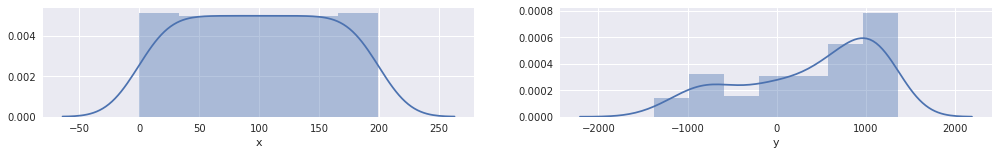

In [14]:
helper.show_numerical(df, kde=True)

#### Target vs numerical features

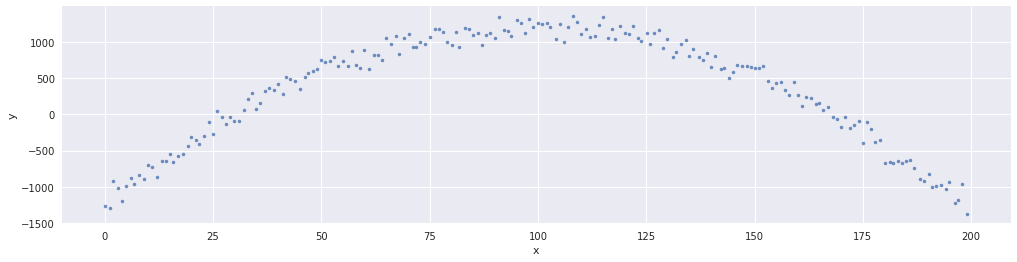

In [15]:
helper.show_target_vs_numerical(df, target, jitter=0.2, fit_reg=False)

#### Correlation between numerical features and target

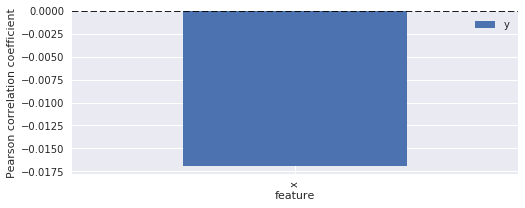

In [16]:
helper.show_correlation(df, target)

#### Most relevant features

In [17]:
copy_df = df.copy()  # checkpoint

## 2. Neural Network model

### Select the features

In [18]:
drop_features = [] # features to drop

df = copy_df.copy() # Restore checkpoint

df.drop(drop_features, axis='columns', inplace=True)
# From now use data instead of df
data = df.copy()
data.head(3)

,x,y
0,0,-1267.686552
1,1,-1296.349709
2,2,-921.096293


### Standarize numerical variables

In [19]:
# Shift and scale the variables such that they have zero mean and a standard deviation of 1. 
# The scaling factors are saved so we can go backwards when we use the network for predictions

data, scale = helper.normalize(data)

### Create dummy features

In [20]:
# features only; target should be encoded later
data, dummies = helper.create_dummy(data, target)

# ordered neural network features (with dummies)
nn_features = [f for f in data if f not in target]

data.head(3)

,x,y
0,-1.719098,-2.159915
1,-1.701821,-2.197800
2,-1.684543,-1.701818


### Split the data into training and test sets

In [21]:
from sklearn.model_selection import train_test_split


def split(data, test_size=0.15):
    train, test = train_test_split(data, test_size=test_size, random_state=9, shuffle=True)

    # Separate the data into features and target (x=features, y=target)
    x_train, y_train = train.drop(target, axis=1).values, train[target].values
    x_test, y_test = test.drop(target, axis=1).values, test[target].values
    # _nc: non-categorical yet (needs one-hot encoding)

    return x_train, y_train, x_test, y_test


x_train, y_train, x_test, y_test = split(data, test_size=0)

### One-hot encode the output

In [22]:
print("train data:", x_train.shape, y_train.shape)
print("test data: ", x_test.shape, y_test.shape)

train data: (200, 1) (200, 1)
test data:  (0, 1) (0, 1)


### Build the Neural Network

In [23]:
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout


def build_nn(input_size, output_size, summary=False):

    input_nodes = input_size*8

    weights = keras.initializers.RandomNormal(stddev=0.00001)

    model = Sequential()
    model.add(
            Dense(
                input_nodes,
                input_dim=input_size,
                activation='relu',
                kernel_initializer=weights,
                bias_initializer='zero'))
    
    #model.add(Dropout(.2))    
    model.add(Dense(1, activation=None, kernel_initializer=weights, bias_initializer='zero'))
    
    #opt = keras.optimizers.adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer='adam')

    if summary:
        model.summary()
        
    return model
    
#model = build_nn(x_train.shape[1], y_train.shape[1], summary=True)

Using TensorFlow backend.


### Train the Neural Network

Training ....
time: 	 6.8 s


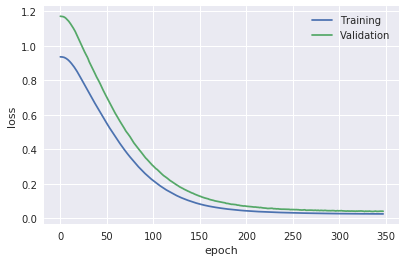


Training loss:  	0.0264
Validation loss: 	0.0420


In [24]:
import os
from time import time
model_path = os.path.join("models", "test.h5")


def train_nn(model, x_train, y_train, validation_data=None, path=False, show=True):
    """ 
    Train the neural network model. If no validation_datais provided, a split for validation
    will be used
    """
    
    if show:
        print('Training ....')
    
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0)]
    t0 = time()

    history = model.fit(
        x_train,
        y_train,
        epochs=1000,
        batch_size=16,
        verbose=0,
        validation_split=0.25,
        validation_data = validation_data,
        callbacks=callbacks)

    if show:
        print("time: \t {:.1f} s".format(time() - t0))
        helper.show_training(history)

    if path:
        model.save(path)
        print("\nModel saved at", path)
    
    return history
        

model = None
model = build_nn(x_train.shape[1], y_train.shape[1], summary=False)
train_nn(model, x_train, y_train);

### Check the model

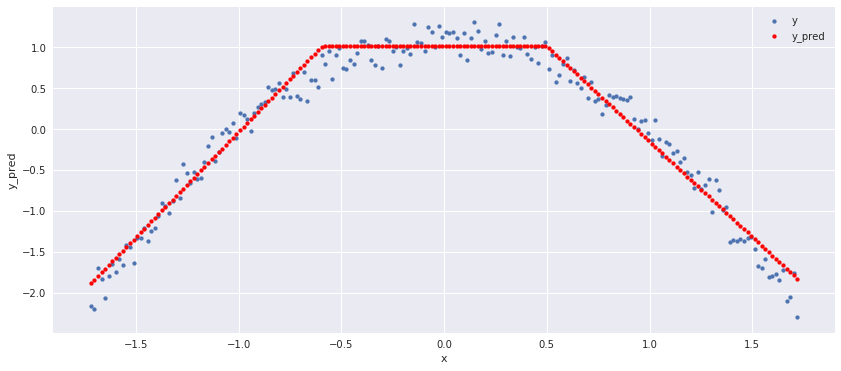

In [25]:
x_test = data.drop(target, axis=1).values

pred = model.predict(x_test, verbose=0)

df_pred = data.copy()
df_pred['y_pred'] = pred

ax = df_pred.plot.scatter('x', 'y', figsize=(14, 6), s=15, label='y')
df_pred.plot.scatter('x', 'y_pred', ax=ax, c='r', s=15, label='y_pred');

### Compare with non-neural network models

#### XGBoost

Training Time:  	 0.022 s


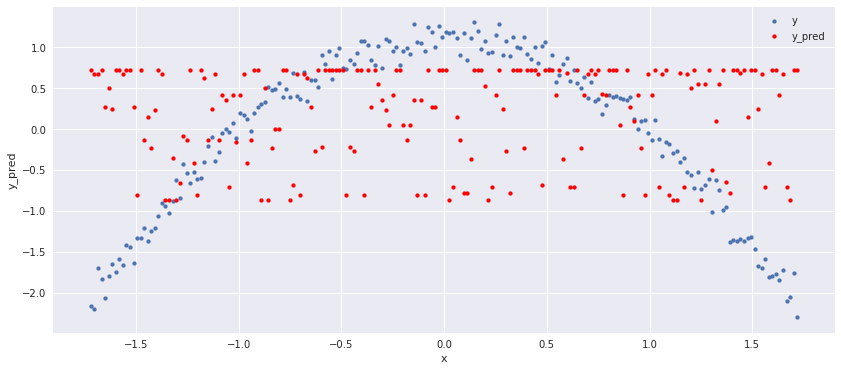

In [29]:
from time import time
import xgboost as xgb

reg=None
reg = xgb.XGBRegressor(max_depth=3,n_estimators=100, learning_rate=0.01)

t0 = time()

reg.fit(x_train, y_train[:, 0])
train_time = time() - t0

print("Training Time:  \t {:.3f} s".format(train_time))

y_pred = reg.predict(x_train)

df_pred2 = data.copy()
df_pred2['y_pred'] = y_pred

ax = df_pred2.plot.scatter('x', 'y', figsize=(14, 6), s=15, label='y')
df_pred2.plot.scatter('x', 'y_pred', ax=ax, c='r', s=15, label='y_pred');

#### Classical Machine Learning

In [30]:
x_test, y_test = x_train, y_train

Training Time:  	 0.003 s


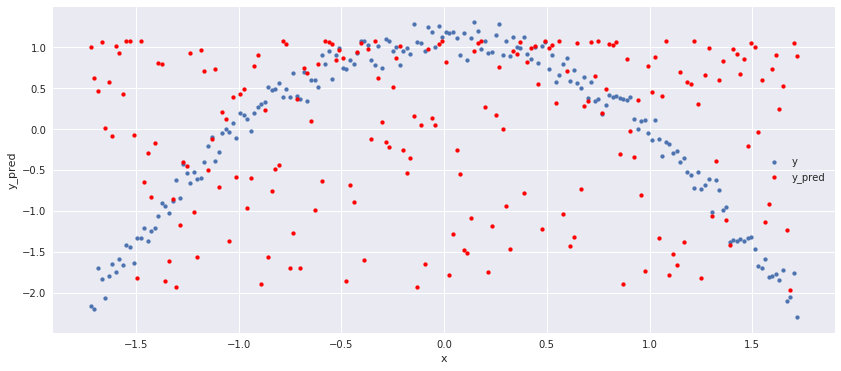

In [31]:
from sklearn.svm import SVR

reg=None
reg = SVR(C=1)

t0 = time()

reg.fit(x_train, y_train[:, 0])

print("Training Time:  \t {:.3f} s".format(time() - t0 ))


train_time = time() - t0
y_pred = reg.predict(x_test)

df_pred3 = data.copy()
df_pred3['y_pred'] = y_pred

ax = df_pred3.plot.scatter('x', 'y', figsize=(14, 6), s=15, label='y')
df_pred3.plot.scatter('x', 'y_pred', ax=ax, c='r', s=15, label='y_pred');